# Modelado de Clasificación de Tumores Cerebrales en Imágenes MRI usando CNN
En este notebook se desarrolla el proceso completo de modelado, entrenamiento y evaluación de una red neuronal convolucional (CNN) para clasificar imágenes MRI preprocesadas en tres tipos de tumores: glioma, meningioma y tumor genérico.

In [13]:
# 1. Importar librerías necesarias
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import datetime


Total de imágenes cargadas: 6056
Dimensiones de las imágenes: (224, 224) (esperado: (224, 224))
Distribución de clases: [2004 2004 2048]


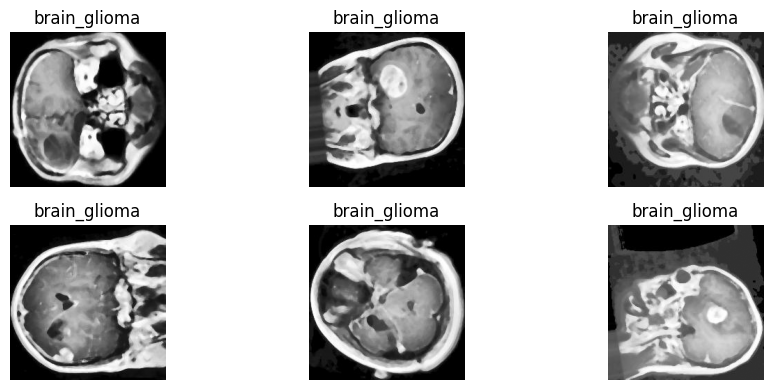

In [14]:
# 2. Cargar y explorar los datos preprocesados

def cargar_datos_preprocesados(ruta_base, clases, img_size=(224, 224)):
    X, y = [], []
    for idx, clase in enumerate(clases):
        ruta_clase = os.path.join(ruta_base, clase)
        for nombre_img in os.listdir(ruta_clase):
            ruta_img = os.path.join(ruta_clase, nombre_img)
            try:
                img = Image.open(ruta_img).convert('L')  # Asumimos imágenes en escala de grises
                img = img.resize(img_size)
                X.append(np.array(img))
                y.append(idx)
            except Exception as e:
                print(f"Error cargando {ruta_img}: {e}")
    X = np.array(X)
    y = np.array(y)
    return X, y

# Definir rutas y clases
RUTA_PREPROCESADAS = '../data/preprocesadas'
CLASES = ['brain_glioma', 'brain_menin', 'brain_tumor']
IMG_SIZE = (224, 224)

# Cargar datos
X, y = cargar_datos_preprocesados(RUTA_PREPROCESADAS, CLASES, IMG_SIZE)
print(f"Total de imágenes cargadas: {X.shape[0]}")
print(f"Dimensiones de las imágenes: {X.shape[1:]} (esperado: {IMG_SIZE})")
print(f"Distribución de clases: {np.bincount(y)}")

# Visualizar algunas imágenes
plt.figure(figsize=(10,4))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i], cmap='gray')
    plt.title(CLASES[y[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()


In [15]:
# 3. Dividir los datos en train, validación y test, y preparar para la CNN

# Normalizar y expandir dimensiones para CNN (canal único)
X = X.astype('float32') / 255.0
X = np.expand_dims(X, axis=-1)

y_cat = to_categorical(y, num_classes=len(CLASES))

# División: 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y_cat, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=np.argmax(y_temp, axis=1), random_state=42)

print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

Train: 4239, Val: 908, Test: 909


In [16]:
# Hiperparámetros óptimos encontrados manualmente:
best_params = {
    'conv_filters': [16, 32, 64],
    'dense_units': 64,
    'dropout_conv': 0.1,
    'dropout_dense': 0.1,
    'lr': 0.0005
}

def crear_modelo(conv_filters, dense_units, dropout_conv, dropout_dense, lr):
    model = Sequential()
    model.add(Conv2D(conv_filters[0], (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(dropout_conv))
    model.add(Conv2D(conv_filters[1], (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(dropout_conv))
    model.add(Conv2D(conv_filters[2], (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(dropout_conv + 0.1))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_dense))
    model.add(Dense(len(CLASES), activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

print("\n[INFO] Entrenando el modelo...")
final_model = crear_modelo(**best_params)

print(final_model.summary())



[INFO] Entrenando el modelo...


d:\Proyectos_programación\mriTumorClassifier\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     2,768,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,792,451 (10.65 MB)

 Trainable params: 2,792,451 (10.65 MB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/40
133/133 ━━━━━━━━━━━━━━━━━━━━ 27s 197ms/step - accuracy: 0.4139 - loss: 1.0782 - val_accuracy: 0.6663 - val_loss: 0.8783
Epoch 2/40
133/133 ━━━━━━━━━━━━━━━━━━━━ 26s 199ms/step - accuracy: 0.6367 - loss: 0.8475 - val_accuracy: 0.7126 - val_loss: 0.7465
Epoch 3/40
133/133 ━━━━━━━━━━━━━━━━━━━━ 26s 195ms/step - accuracy: 0.7066 - loss: 0.6949 - val_accuracy: 0.7137 - val_loss: 0.6636
Epoch 4/40
133/133 ━━━━━━━━━━━━━━━━━━━━ 26s 195ms/step - accuracy: 0.7668 - loss: 0.5688 - val_accuracy: 0.7930 - val_loss: 0.5228
Epoch 5/40
133/133 ━━━━━━━━━━━━━━━━━━━━ 26s 197ms/step - accuracy: 0.7912 - loss: 0.5025 - val_accuracy: 0.7753 - val_loss: 0.5381
Epoch 6/40
133/133 ━━━━━━━━━━━━━━━━━━━━ 26s 196ms/step - accuracy: 0.8081 - loss: 0.4657 - val_accuracy: 0.7720 - val_loss: 0.5033
Epoch 7/40
133/133 ━━━━━━━━━━━━━━━━━━━━ 26s 198ms/step - accuracy: 0.8586 - loss: 0.3383 - val_accuracy: 0.8205 - val_loss: 0.4296
Epoch 8/40
133/133 ━━━━━━━━━━━━━━━━━━━━ 26s 198ms/step - accuracy: 0.8874 - loss: 0

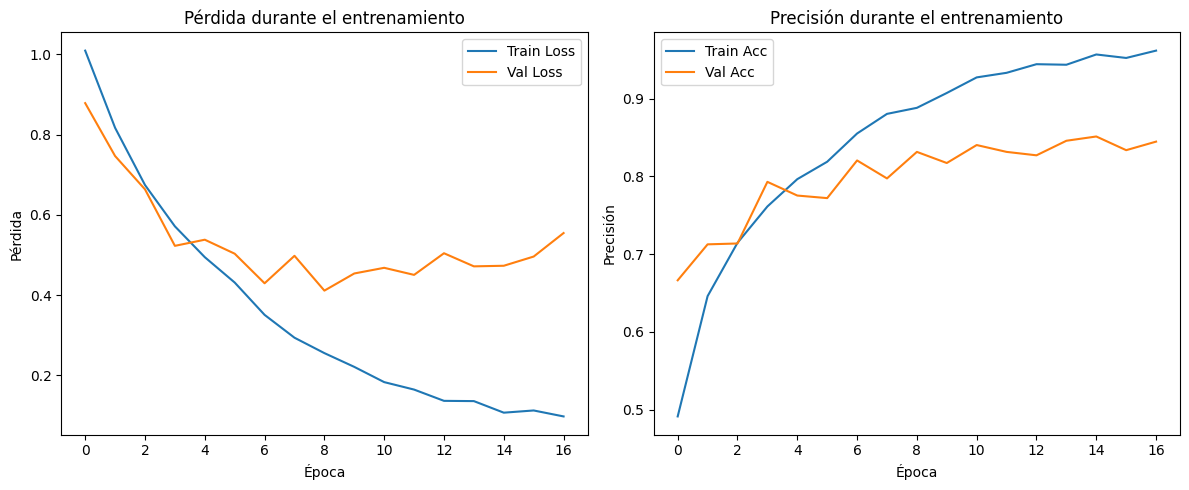

In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history_final = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Visualización de la historia de entrenamiento final
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_final.history['loss'], label='Train Loss')
plt.plot(history_final.history['val_loss'], label='Val Loss')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_final.history['accuracy'], label='Train Acc')
plt.plot(history_final.history['val_accuracy'], label='Val Acc')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
# 6. Guardar el modelo final con precisión de validación en el nombre
MODELOS_DIR = '../models'
os.makedirs(MODELOS_DIR, exist_ok=True)
fecha_hora = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
val_acc_final = max(history_final.history['val_accuracy'])
nombre_modelo = f"cnn_mri_{fecha_hora}_valacc_{val_acc_final:.4f}.h5"
ruta_modelo = os.path.join(MODELOS_DIR, nombre_modelo)
final_model.save(ruta_modelo)
print(f"Modelo final guardado en: {ruta_modelo}")

Modelo final guardado en: ../models\cnn_mri_20250703_183653_valacc_0.8513.h5
